ФИО: Лыжин Роман

### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [ ]:
class Config:
    pass

config = Config()
config.batch_size = 64
config.num_workers = 2
config.num_epochs = 2
config.noise_size = 100
config.n_critic = 5
config.clip_value = 0.01
config.lambda_gp = 10
config.print_freq = 100
config.lr = 0.00005
config.num_classes = 10
config.embed_size = 10

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.99MB/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.97MB/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

In [ ]:
len(dataloader)

938

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

torch.Size([64, 1, 28, 28])

In [ ]:
28*28

784

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## WGAN с weight clipping

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, out_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

class Critic(nn.Module):
    def __init__(self, in_dim=784):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator(config.noise_size).to(device)
critic = Critic().to(device)

In [ ]:
optim_G = optim.RMSprop(generator.parameters(), lr=config.lr)
optim_D = optim.RMSprop(critic.parameters(), lr=config.lr)

In [ ]:
fixed_noise = torch.randn(config.batch_size, config.noise_size).to(device)

In [ ]:
ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    i = 0
    data_iter = iter(dataloader)
    for images, _ in dataloader:
        i += 1
        images = images.to(device)
        images = images.view(images.size(0), -1)
        for p in critic.parameters():
            p.requires_grad = True
        for _ in range(config.n_critic):
            try:
                data = next(data_iter)
            except:
                data_iter = iter(dataloader)
                data = next(data_iter)
            real_data = data[0].to(device).view(data[0].size(0), -1)
            noise = torch.randn(real_data.size(0), config.noise_size).to(device)
            fake_data = generator(noise)
            optim_D.zero_grad()
            critic_real = critic(real_data)
            critic_fake = critic(fake_data.detach())
            d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake))
            d_loss.backward()
            optim_D.step()
            for p in critic.parameters():
                p.data.clamp_(-config.clip_value, config.clip_value)
        for p in critic.parameters():
            p.requires_grad = False
        noise = torch.randn(images.size(0), config.noise_size).to(device)
        fake_data = generator(noise)
        optim_G.zero_grad()
        critic_fake = critic(fake_data)
        g_loss = -torch.mean(critic_fake)
        g_loss.backward()
        optim_G.step()
        ERRD[epoch] += d_loss.item()
        ERRG[epoch] += g_loss.item()
        if i % config.print_freq == 0:
            print('Epoch:{} Iter:{} D-loss:{:.4f} G-loss:{:.4f}'.format(epoch+1, i, d_loss.item(), g_loss.item()))

Epoch:1 Iter:100 D-loss:0.5101 G-loss:-0.7645
Epoch:1 Iter:200 D-loss:0.3688 G-loss:-1.6250
Epoch:1 Iter:300 D-loss:-0.1594 G-loss:0.0873
Epoch:1 Iter:400 D-loss:-1.1420 G-loss:1.0993
Epoch:1 Iter:500 D-loss:-0.5515 G-loss:-0.4131
Epoch:1 Iter:600 D-loss:-0.7649 G-loss:-0.2684
Epoch:1 Iter:700 D-loss:0.2027 G-loss:-3.2596
Epoch:1 Iter:800 D-loss:-0.4546 G-loss:-0.0987
Epoch:1 Iter:900 D-loss:-0.7195 G-loss:-1.9584
Epoch:2 Iter:100 D-loss:-0.5473 G-loss:0.5091
Epoch:2 Iter:200 D-loss:-1.1570 G-loss:-0.6641
Epoch:2 Iter:300 D-loss:-0.1289 G-loss:-1.0991
Epoch:2 Iter:400 D-loss:-0.7249 G-loss:2.8993
Epoch:2 Iter:500 D-loss:-0.1997 G-loss:-0.5956
Epoch:2 Iter:600 D-loss:-0.6149 G-loss:-0.9447
Epoch:2 Iter:700 D-loss:-0.7782 G-loss:-0.3971
Epoch:2 Iter:800 D-loss:-0.3397 G-loss:-0.3683
Epoch:2 Iter:900 D-loss:-0.4364 G-loss:0.2538


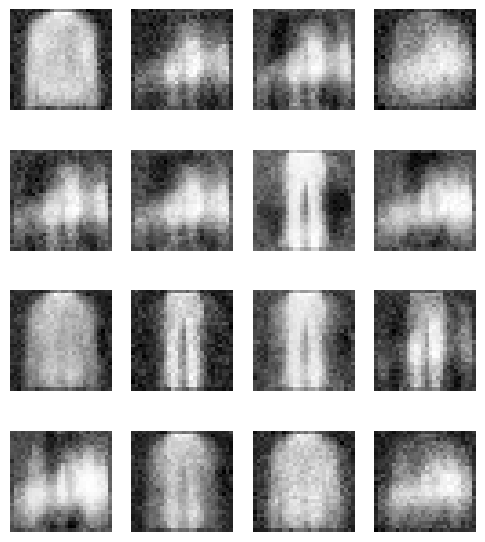

In [ ]:
noise = fixed_noise
fake = generator(noise).detach().cpu().numpy()
plt.figure(figsize=(6,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((fake[i].reshape(28,28)+1)/2, cmap='gray')
    plt.axis('off')
plt.show()

##WGAN-GP

In [ ]:
from torch.autograd import grad

def gradient_penalty(critic, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).to(real_data.device)
    alpha = alpha.expand(real_data.size())
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)
    disc_interpolates = critic(interpolates)
    grad_outputs = torch.ones(disc_interpolates.size()).to(real_data.device)
    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_pen = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * config.lambda_gp
    return gradient_pen

In [ ]:
optim_G = optim.Adam(generator.parameters(), lr=config.lr, betas=(0.5,0.9))
optim_D = optim.Adam(critic.parameters(), lr=config.lr, betas=(0.5,0.9))

In [ ]:
ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    i = 0
    data_iter = iter(dataloader)
    for images, _ in dataloader:
        i += 1
        images = images.to(device)
        images = images.view(images.size(0), -1)
        for p in critic.parameters():
            p.requires_grad = True
        for _ in range(config.n_critic):
            try:
                data = next(data_iter)
            except:
                data_iter = iter(dataloader)
                data = next(data_iter)
            real_data = data[0].to(device).view(data[0].size(0), -1)
            noise = torch.randn(real_data.size(0), config.noise_size).to(device)
            fake_data = generator(noise)
            optim_D.zero_grad()
            critic_real = critic(real_data)
            critic_fake = critic(fake_data.detach())
            gp = gradient_penalty(critic, real_data, fake_data)
            d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
            d_loss.backward()
            optim_D.step()
        for p in critic.parameters():
            p.requires_grad = False
        noise = torch.randn(images.size(0), config.noise_size).to(device)
        fake_data = generator(noise)
        optim_G.zero_grad()
        critic_fake = critic(fake_data)
        g_loss = -torch.mean(critic_fake)
        g_loss.backward()
        optim_G.step()
        ERRD[epoch] += d_loss.item()
        ERRG[epoch] += g_loss.item()
        if i % config.print_freq == 0:
            print('Epoch:{} Iter:{} D-loss:{:.4f} G-loss:{:.4f}'.format(epoch+1, i, d_loss.item(), g_loss.item()))


Epoch:1 Iter:100 D-loss:-2.0246 G-loss:-0.3738
Epoch:1 Iter:200 D-loss:-1.1514 G-loss:0.8863
Epoch:1 Iter:300 D-loss:-2.1597 G-loss:0.0493
Epoch:1 Iter:400 D-loss:-3.0975 G-loss:-1.1300
Epoch:1 Iter:500 D-loss:-2.0076 G-loss:-0.9127
Epoch:1 Iter:600 D-loss:-2.0316 G-loss:-0.0677
Epoch:1 Iter:700 D-loss:-2.1106 G-loss:-0.9734
Epoch:1 Iter:800 D-loss:-1.7647 G-loss:-1.2991
Epoch:1 Iter:900 D-loss:-1.6026 G-loss:-1.2113
Epoch:2 Iter:100 D-loss:-1.9338 G-loss:1.3699
Epoch:2 Iter:200 D-loss:-2.2374 G-loss:0.7660
Epoch:2 Iter:300 D-loss:-2.0776 G-loss:1.1052
Epoch:2 Iter:400 D-loss:-2.2164 G-loss:0.1837
Epoch:2 Iter:500 D-loss:-2.2611 G-loss:1.4281
Epoch:2 Iter:600 D-loss:-2.1601 G-loss:1.4253
Epoch:2 Iter:700 D-loss:-2.2020 G-loss:0.7759
Epoch:2 Iter:800 D-loss:-2.3689 G-loss:-0.0873
Epoch:2 Iter:900 D-loss:-1.9701 G-loss:1.1312


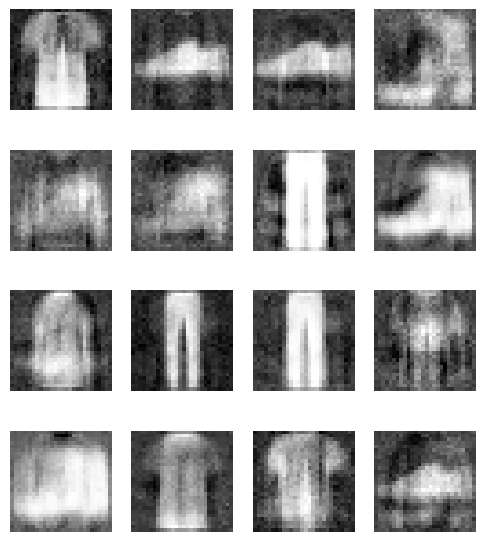

In [ ]:
noise = fixed_noise
fake = generator(noise).detach().cpu().numpy()
plt.figure(figsize=(6,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((fake[i].reshape(28,28)+1)/2, cmap='gray')
    plt.axis('off')
plt.show()

## Условный WGAN-GP

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, embed_dim=10, out_dim=784, num_classes=10):
        super(ConditionalGenerator, self).__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim+embed_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, out_dim),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        e = self.embed(labels)
        x = torch.cat([noise, e], dim=1)
        return self.model(x)

class ConditionalCritic(nn.Module):
    def __init__(self, in_dim=784, embed_dim=10, num_classes=10):
        super(ConditionalCritic, self).__init__()
        self.embed = nn.Embedding(num_classes, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(in_dim+embed_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x, labels):
        e = self.embed(labels)
        y = torch.cat([x, e], dim=1)
        return self.model(y)

In [ ]:
def gradient_penalty(critic, real_data, fake_data, labels):
    alpha = torch.rand(real_data.size(0), 1).to(real_data.device)
    alpha = alpha.expand(real_data.size())
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)
    disc_interpolates = critic(interpolates, labels)
    grad_outputs = torch.ones(disc_interpolates.size()).to(real_data.device)
    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_pen = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * config.lambda_gp
    return gradient_pen

In [ ]:
generator = ConditionalGenerator(config.noise_size, config.embed_size).to(device)
critic = ConditionalCritic().to(device)

In [ ]:
optim_G = optim.Adam(generator.parameters(), lr=config.lr, betas=(0.5,0.9))
optim_D = optim.Adam(critic.parameters(), lr=config.lr, betas=(0.5,0.9))

In [ ]:
fixed_labels = torch.randint(0, config.num_classes, (config.batch_size,)).to(device)

In [ ]:
ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    i = 0
    data_iter = iter(dataloader)
    for images, labs in dataloader:
        i += 1
        images = images.to(device)
        labs = labs.to(device)
        images = images.view(images.size(0), -1)
        for p in critic.parameters():
            p.requires_grad = True
        for _ in range(config.n_critic):
            try:
                data = next(data_iter)
            except:
                data_iter = iter(dataloader)
                data = next(data_iter)
            real_data = data[0].to(device).view(data[0].size(0), -1)
            real_labels = data[1].to(device)
            noise = torch.randn(real_data.size(0), config.noise_size).to(device)
            fake_labels = torch.randint(0, config.num_classes, (real_data.size(0),)).to(device)
            fake_data = generator(noise, fake_labels)
            optim_D.zero_grad()
            critic_real = critic(real_data, real_labels)
            critic_fake = critic(fake_data.detach(), fake_labels)
            gp = gradient_penalty(critic, real_data, fake_data, real_labels)
            d_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + gp
            d_loss.backward()
            optim_D.step()
        for p in critic.parameters():
            p.requires_grad = False
        noise = torch.randn(images.size(0), config.noise_size).to(device)
        fake_labels = torch.randint(0, config.num_classes, (images.size(0),)).to(device)
        fake_data = generator(noise, fake_labels)
        optim_G.zero_grad()
        critic_fake = critic(fake_data, fake_labels)
        g_loss = -torch.mean(critic_fake)
        g_loss.backward()
        optim_G.step()
        ERRD[epoch] += d_loss.item()
        ERRG[epoch] += g_loss.item()
        if i % config.print_freq == 0:
            print('Epoch:{} Iter:{} D-loss:{:.4f} G-loss:{:.4f}'.format(epoch+1, i, d_loss.item(), g_loss.item()))

Epoch:1 Iter:100 D-loss:-2.1328 G-loss:0.3201
Epoch:1 Iter:200 D-loss:-4.5735 G-loss:-0.1777
Epoch:1 Iter:300 D-loss:-3.2404 G-loss:-1.1594
Epoch:1 Iter:400 D-loss:-2.8851 G-loss:-0.4455
Epoch:1 Iter:500 D-loss:-2.7233 G-loss:0.1593
Epoch:1 Iter:600 D-loss:-2.8013 G-loss:1.2378
Epoch:1 Iter:700 D-loss:-2.9034 G-loss:0.8782
Epoch:1 Iter:800 D-loss:-3.0627 G-loss:2.2866
Epoch:1 Iter:900 D-loss:-3.1899 G-loss:0.0002
Epoch:2 Iter:100 D-loss:-3.2219 G-loss:1.7079
Epoch:2 Iter:200 D-loss:-3.2404 G-loss:0.3930
Epoch:2 Iter:300 D-loss:-3.1950 G-loss:1.0674
Epoch:2 Iter:400 D-loss:-3.1156 G-loss:0.5573
Epoch:2 Iter:500 D-loss:-3.1670 G-loss:0.1934
Epoch:2 Iter:600 D-loss:-2.7903 G-loss:0.9262
Epoch:2 Iter:700 D-loss:-2.2707 G-loss:-0.3574
Epoch:2 Iter:800 D-loss:-2.6062 G-loss:-0.1037
Epoch:2 Iter:900 D-loss:-2.4273 G-loss:-0.0481


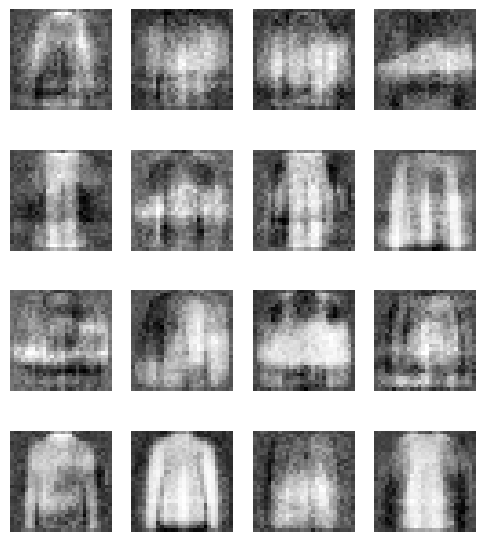

In [ ]:
noise = fixed_noise
labels_for_show = torch.randint(0, config.num_classes, (config.batch_size,)).to(device)
fake = generator(noise, labels_for_show).detach().cpu().numpy()
plt.figure(figsize=(6,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((fake[i].reshape(28,28)+1)/2, cmap='gray')
    plt.axis('off')
plt.show()

## Вывод

Были протестированы три варианта GAN:

1. WGAN с использованием weight clipping.

Общая структура элементов более менее прослеживается, но изображения всё же размытые, нечёткие, и трудно понять, что это за объект, а также отличить их от других изображений. Наблюдался большой перепад значений потерь между итерациями, что свидетельствует о слабости weight clipping как метода регуляризации. Ограничение весов критика снижало его способность точно оценивать различия между распределениями реальных и фейковых данных.

2. WGAN-GP с заменой weight clipping на градиентный штраф.

Сгенерированные изображения были четче и больше напоминали реальные объекты - конкретную одежду. Потери генератора и критика не изменялись так резко, что говорит о стабильной сходимости. Градиентный штраф позволил избежать проблем, связанных с weight clipping, критик смог оценивать Wasserstein-расстояние точнее. Регуляризация через градиентный штраф улучшила обучаемость генератора.

3. Условный WGAN-GP с использованием информации о метках классов для условной генерации.

Изображения стали ещё более чёткими. Потери демонстрировали предсказуемую динамику, что указывает на устойчивость модели. Условная генерация позволила точно контролировать создаваемые классы. Добавление информации о метках помогло генератору лучше изучить распределение данных.